# Nondeterminism in Qiskit and Qiskit IBM Runtime client

This notebook explores in detail the reasons why the quantum artifacts (as defined in Section 4 of the paper) generated with Qiskit are not reproducible.

This corresponds to Section 8 in the paper.

## Index

1. [Quantum artifacts](#Quantum-artifacts)
    1. [Capturing the binary payloads](#Capturing-the-binary-payloads)
2. [Sources of nondeterminism](#Sources-of-nondeterminism)
    1. [Transpilation seed](#Transpilation-seed)
    2. [QPY encoding](#QPY-encoding)
        1. [Unnamed circuits](#Unnamed-circuits)
        2. [Circuits with parameters](#Circuits-with-parameters)
3. [Deterministic artifacts with OpenQASM3](#Deterministic-artifacts-with-OpenQASM3)
    1. [Testing unnamed circuits](#Testing-unnamed-circuits)
    2. [Testing circuits with parameters](#Testing-circuits-with-parameters)
    3. [Testing large random transpiled circuits](#Testing-large-random-transpiled-circuits)
4. [Impact on quantum artifacts size](#Impact-on-quantum-artifacts-size)

In [1]:
import qiskit
import qiskit_ibm_runtime

print(f"Qiskit version: {qiskit.version.get_version_info()}")
print(f"Qiskit IBM Runtime version: {qiskit_ibm_runtime.version.get_version_info()}")

Qiskit version: 2.2.1
Qiskit IBM Runtime version: 0.42.0


<div class="alert alert-block alert-warning">
All the explanations and links to code blocks are to <a href="https://github.com/Qiskit/qiskit-ibm-runtime/tree/0.42.0">version 0.42.0 of the Qikit IBM Runtime package</a> and <a href="https://github.com/Qiskit/qiskit/tree/2.2.1">version 2.2.1</a> of Qiskit. If the versions shown above differ from these, some discrepancies may occur because Qiskit is under active development.
</div>

---

## Quantum artifacts

We define quantum artifacts (see Sec. 4 of the paper) as

<div class="alert alert-block alert-info">
(...) the code (binary or not) that is fed into a QPU running the quantum experiment defined by its source code.
</div>


In the case of IBM's quantum backends, the quantum artifact is the binary payload containing the transpiled circuit, since this is the data sent by the user to the IBM Quantum Platform to be executed on their QPUs.

This binary payload is generated in the [`runtime.py` module](https://github.com/Qiskit/qiskit-ibm-runtime/blob/0.42.0/qiskit_ibm_runtime/api/rest/runtime.py). In particular, in the function [`program_run()`](https://github.com/Qiskit/qiskit-ibm-runtime/blob/f0fd1066df318e40afeebcb40ecee0c5448b617a/qiskit_ibm_runtime/api/rest/runtime.py#L64-L121) the Python object is serialized into a JSON payload.

This encoding is implemented in the [`json.py` module](https://github.com/Qiskit/qiskit-ibm-runtime/blob/0.42.0/qiskit_ibm_runtime/utils/json.py). In particular, in the [`RuntimeEncoder`](https://github.com/Qiskit/qiskit-ibm-runtime/blob/f0fd1066df318e40afeebcb40ecee0c5448b617a/qiskit_ibm_runtime/utils/json.py#L240-L417) class.

All the different objects are passed through that class when `json.dumps()` is called, and each one is serialized (and sometimes compressed) using different methods depending on the type of the object. For example, `QuantumCircuit` objects are converted to a binary string using the [QPY format](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qpy). Then this string is compressed using [`zlib`](https://docs.python.org/3/library/zlib.html) and the compressed output is encoded as a UTF-8 Base64 string.



### Capturing the binary payloads

Submitting jobs to the IBM Quantum Platform costs money. Accounts with the Open Plan can run 10 minutes of quantum computations for free per month. Nevertheless, we would like to obtain and test the quantum artifacts for reproducibility without sending them to the IBM Quantum Platform. This is possible in two different ways.

1. Using Qiskit and Qiskit IBM Runtime as usual, but set a proxy that intercepts and blocks the payload. This can be done, for example, using the [Burp Suite](https://portswigger.net/) or the open-source [mitmproxy](https://www.mitmproxy.org/).
2. Alternatively, we can mimic the code in Qiskit IBM Runtime that generates the quantum artifact and check that instead.

In this notebook, we will use option 2 since it does not require any additional software. For simplicity, we will use `QPY.dumps()` directly on the transpiled circuits. This is not exactly the same payload we would capture with option 1, but any noticeable changes here are guaranteed to remain in the final artifact, i.e., the payload that contains that encoded circuit plus additional (reproducible or not) metadata.

In [2]:
import json
from qiskit import QuantumCircuit, generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeTorino
from qiskit_ibm_runtime.utils import RuntimeEncoder

In [3]:
backend = FakeTorino()

If you have an IBM Quantum Platform account and have followed [the instructions to configure and save it](https://quantum.cloud.ibm.com/docs/en/guides/cloud-setup), you can uncomment the cell below to use the latest noise model from a real quantum backend. Otherwise, feel free to continue with the rest of the notebook using the noise model from the old snapshot.

In [4]:
#service = QiskitRuntimeService()
#backend = service.backend("ibm_torino")

We create a very simple 1-qubit quantum circuit and transpile it.

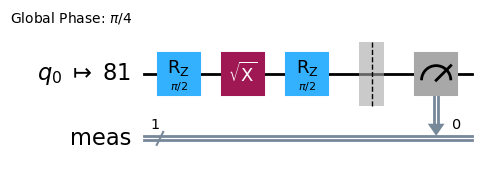

In [5]:
qc = QuantumCircuit(1)
qc.h(0)
qc.measure_all()
pm = generate_preset_pass_manager(backend=backend)
isa_qc = pm.run(qc)
isa_qc.draw("mpl")

No we obtain (part of) the binary payload.

In [6]:
payload = json.dumps(isa_qc, cls=RuntimeEncoder)
print(payload)

{"__type__": "QuantumCircuit", "__value__": "eJyl12VUVWkYhuG9McBuxRa7sLswMLAV7MQjKorBEewWp7u7u7u7u7t7xumecZwZh8d9gz5rxl+z19KLWzmgru973+OkjMwxGVlVExLCIHrCVflBxUVBUvGHu5T8cgI/9JTTT7HceKwwtyC1R6+03Sl7s9JTkzduzg/3vyoM8wN/Dv4qespg2YO/YvFTHhMxCStgRayElbEKVsVqWB1rYE2shbWxDtbFepiM9bEBNsRG2BibYFNshinYHFtgS2yFrbENtsV22B47YEdMxU7YGbtgV+yG3bEH9sRe2Bv7YF/sh/1xAA7EQZiGg3EIDsVhmI7DcQSOxFGYgaNxDI7FcTgeJ+BEnISTMROzcApOxWk4HWfgTJyFs3EOzsV5OB+zcQHGcCHm4CJcjEswF5fiMszD5bgCV+IqLLmPcVyNBViIa3AtrsP1uAE34ibcjFtwK27D7bgDd2JRTJMhDMqGy3OyS/5QB57yQTQ6wn/9TvRMnjkyuyBHf7lJJf9yScmp6Vl7U/aklc6SQ704c3rpi//fNyoZVod68dDseDw3Jx59p4M/+b9eMK7436EwHn2r2IFP1Sjeta/4CaIhGu4ftUVBYpi9Ipabl1dywIpwFx6Gh+MReCQehUfjMXgsHofH4wl4Ip6EJ+MpeCqehqfjGXgmnoVn4zl4Lp6H5+MFeCFehBfjJXgpXoaX4xV4JV6FV+M1eC1eh9fjDXgj3oQ34y14K96Gt+MdeCfehXfjPXgv3of34wP4ID6ED+Mj+Cg+ho/jE/gkPoVP4zP4LD6Hz+ML+CK+hC/jK/gqvoav4xv4Jr6Fb+M7+C6+h+/jB/ghfoQf4yf4KX6Gn+MXuBu/xK/wa/wGv8Xv8Hv8AX/En/Bn/AV/xd/wd9yDf+Be/BP/wr9xX0TpmzQ+CHlDFfKGKuQNVcgbqpAhGCbmRwOn9K1ZWPKWKvHAAAk9Ezz

If, instead, we had used the `SamplerV2.run()` method to submit the job with 2000 shots, the full payload would have been the following.

```json
{
    "program_id": "sampler",
    "params": {
        "pubs": [
            [
                {
                    "__type__": "QuantumCircuit",
                    "__value__": "eJyl12VUVWkYhuG9McBuxRa7ULEbAwNbwU48oqIYINgtTnd3d3d3d3f3jNM94zgzDo/7PuqzZvw1ey29uJUD6vq+9z1OzMwanZldNSFMCKInXFkQVFoYJJV+uFPJLyfwQ085/RTLK4wV5xWlpvVKS9+Vsic7IzV5w6aCcN/LwrAg8OfgL6OnDJY9+EuWPuUxEZOwAlbESlgZq2BVrIbVsQbWxFpYG+tgXayHyVgfG2BDbISNsQk2xWaYgs2xBbbEVtga22BbbIftsQN2xFTshJ2xC6ZhV+yG3bEH9sRe2Bv7YF/sh/1xAA7EdByEg3EIDsUMHIbDcQSOxEwchaNxDI7FcTgeJ+BEnIRZmI2TcQpOxWk4HWfgTJyFs3EOzsV5mIPzMYYLMBcX4iJcjHm4BJdiPi7D5bgCV2L8PhbiKizCYlyNa3AtrsP1uAE34ibcjFtwK27D7bgDS2KaDGFQNlyWmxP/Qx14ygfR6Aj/9TvRM2nGiJyiXP3lhsT/5ZKSUzOy96TsTt8/Sw714qxp+1/8/75RfFgd6sVDcgoL83ILo+908Cf/1wvGlv47FBdG3yp24FM1i3fuLX2CaIiG+0ZtSZAY5iyP5eXnxw9YCe7Ew/BwPAKPxKPwaDwGj8Xj8Hg8AU/Ek/BkPAVPxdPwdDwDz8Sz8Gw8B8/F8/B8vAAvxIvwYrwEL8XL8HK8Aq/Eq/BqvAavxevwerwBb8Sb8Ga8BW/F2/B2vAPvxLvwbrwH78X78H58AB/Eh/BhfAQfxcfwcXwCn8Sn8Gl8Bp/F5/B5fAFfxJfwZXwFX8XX8HV8A9/Et/BtfAffxffwffwAP8SP8GP8BD/Fz/Bz/AJ34Zf4FX6N3+C3+B1+jz/gj/gT/oy/4K/4G/6Ou/EP3IN/4l/4N+6NiE+MkA/ib9tC3lCFvKEKeUMVMgTDxIJo4Ox/axbG31IlHhggoWeCZxnPsp7lPMt7JnomeVbwrOhZybOyZxXPqp7VPKt71vCs6VnLs7ZnHc+6nvU8kz3rezbwbOjZyLOxZxPPpp7NPFM8m3u28Gzp2cqztWcbz7ae7Tzbe3bw7OiZ6tnJs7NnF880z66e3Ty7e/bw7OnZy7O3Zx/Pvp79PPt7DvAc6JnuOchzsKeeMHrXYb8+1DPDc5jncM8RniM9Mz1HeY72HOM51nOc53jPCZ4TPSd5Znlme072nOI51XOa53TPGZ4zPWd5zvac4znXc55njud8z5jnAs9cz4WeizwXe+Z5LvFc6pnvucxzuecKz5WeBZ6Fnqs8izyLPVd7rvFc67nOc73nBs+Nnps8N3tu8dzquc1zu+cOz/j/qcMgWtna01rO2sj71nAQLVxtWa1W7VMtUW1OrUvtSC1GbUOtQO09LTttOK017TItMG0trSrtJy0lbSKtH+2cZkG0XbRStEe0PLQxtCa0G7QQtAU0+jXvNeQ12TXONcM1uDWtNaI1lzWMNYE1djVrNWA1VTVKNT81NDUpNR41EwcF0fTTaNM80xDT5NK40ozSYNI00gjS3NGw0YTRWNEs0QDR1NCo0HzQUNAk0PXXnddF1+3WldY91uXVjdU1nRdEF1K3UFdP902XTDdL10l3SBdHt0VXRPdCl0E3QMdeZ10HXKdaR1nnV4dWJ1XHU2dSB1GnT0dO50yHSydKx2hrEB0YnRIdjZJ/ABaPbgY="
                },
                {
                    "__type__": "ndarray",
                    "__value__": "eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RoGOpo6CrUKFAAuAFOzG1s="
                },
                2000
            ]
        ],
        "options": {},
        "version": 2,
        "support_qiskit": true
    },
    "log_level": "WARNING",
    "backend": "ibm_torino"
}
```

Note that the interesting part that can introduce nondeterminism is just the encoded `QuantumCircuit`. In this particular case, the `ndarray` inside the submitted "pubs" is just an empty array, which we can safely ignore.

In [7]:
import base64
import io
import zlib
import numpy as np

In [8]:
arr = np.array([], dtype=np.float64)

with io.BytesIO() as buff:
    np.save(buff, arr)
    buff.seek(0)
    serialized_data = buff.read()

serialized_data = zlib.compress(serialized_data)
final_string = base64.standard_b64encode(serialized_data).decode("utf-8")
print(final_string)

eJyb7BfqGxDJyFDGUK2eklqcXKRupaBuk2ahrqOgnpZfVFKUmBefX5SSChJ3S8wpTgWKF2ckFqQC+RoGOpo6CrUKFAAuAFOzG1s=


## Sources of nondeterminism

### Transpilation seed

Qiskit uses a seed in functions like [`transpile()`](https://quantum.cloud.ibm.com/docs/en/api/qiskit/compiler#transpile) and [`generate_preset_pass_manager()`](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.transpiler.generate_preset_pass_manager#qiskittranspilergenerate_preset_pass_manager) because several steps of circuit optimization and backend mapping involve randomized heuristics. For example, the layout selection pass may randomly choose an initial qubit mapping, stochastic optimization passes can explore different gate reorderings, and tie-breaking between equivalent solutions may use randomness. By supplying a seed, it is possible to ensure that these random decisions are made deterministically, so that the transpilation pipeline produces the same circuits across runs. Without a fixed seed, results may vary from call to call, even for the same input circuit and backend configuration.

This is why this seed used for the transpilation can lead to different transpiled circuits. When circuits are too small or simple, the transpilation might be deterministic even when using different seeds, but in our experience circuits with more than a few qubits are already non-reproducible when the seed used by the transpilation passes is not fixed.

In [9]:
import secrets
from qiskit.circuit.random import random_circuit

First, we create a relatively small random circuit.

seed_random_circuit = 4092312379883486539


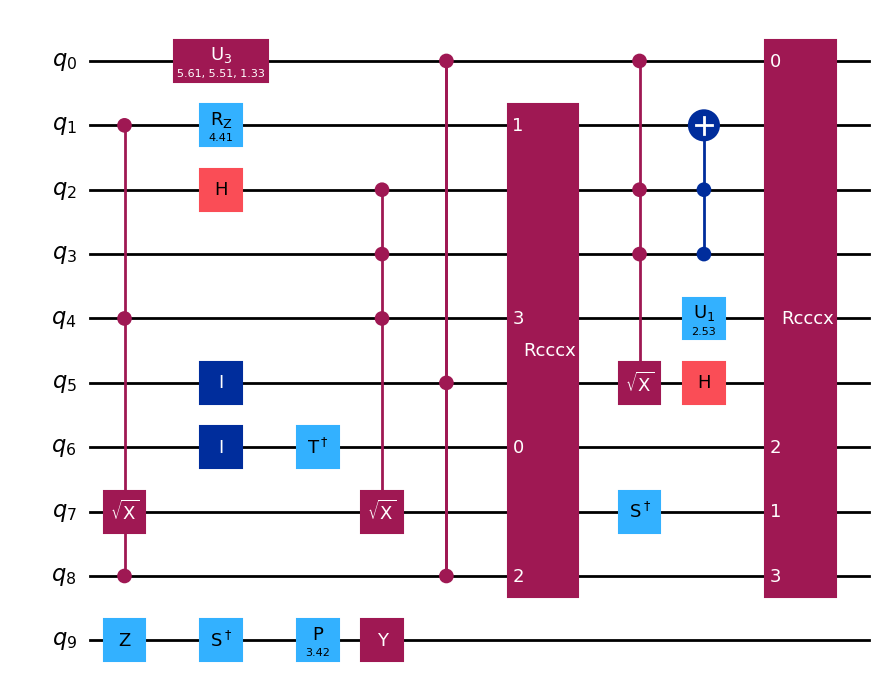

In [10]:
# This seed is not relevant for reproducible builds, it's just to pick one particular random circuit
# so that it is possible to reproduce the results in this notebook
# seed_random_circuit = secrets.randbits(64)
seed_random_circuit = 4092312379883486539
print(f"seed_random_circuit = {seed_random_circuit}")
qc = random_circuit(num_qubits=10, depth=4, seed=seed_random_circuit)
qc.draw("mpl")

Now we transpile it using two different seeds. When the seed is not specified, Qiskit uses a fresh random one.

seed_transpilation_1 = 18401311231943199421
seed_transpilation_2 = 5211256050749190951


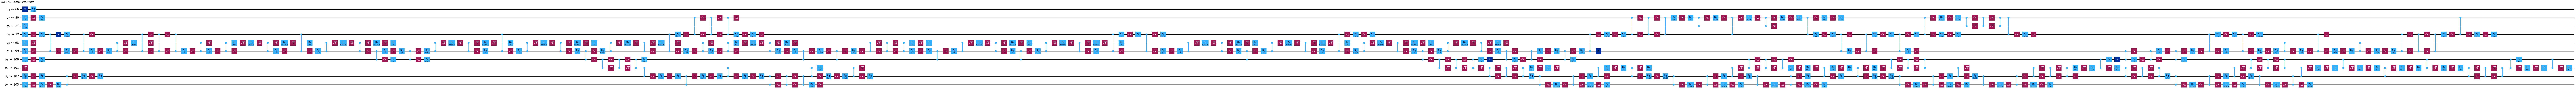

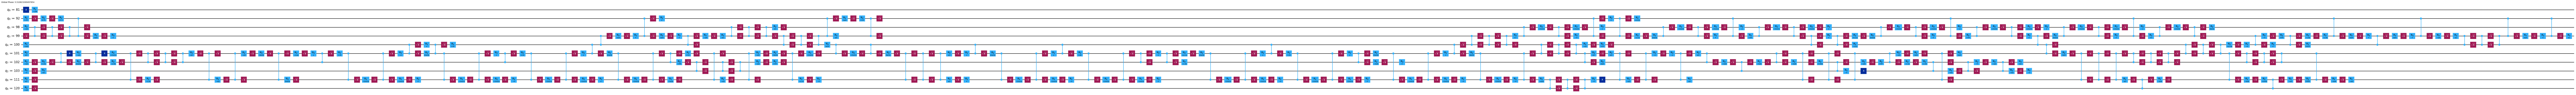

In [11]:
# These are the relevant seeds, since if not distributed as part of the source code, they will lead to non-reproducible builds
seed_transpilation_1 = secrets.randbits(64)
seed_transpilation_2 = secrets.randbits(64)
print(f"seed_transpilation_1 = {seed_transpilation_1}")
print(f"seed_transpilation_2 = {seed_transpilation_2}")

# Two pass managers initialized with different seeds
pm_1 = generate_preset_pass_manager(backend=backend, seed_transpiler=seed_transpilation_1)
pm_2 = generate_preset_pass_manager(backend=backend, seed_transpiler=seed_transpilation_2)

# Transpiled circuits
isa_qc_1 = pm_1.run(qc)
isa_qc_2 = pm_2.run(qc)

# The transpiled circuits are quite large and when drawn with fold=False, it is hard to see the details
# Nevertheless, already from the very beginning, it is possible to observe that they are different circuits.
display(isa_qc_1.draw("mpl", fold=False))
display(isa_qc_2.draw("mpl", fold=False))

We do a proper check by obtaining the final artifact and comparing the strings.

In [12]:
# Encoded payloads (compressed and base64 encoded QPY objects)
payload_1 = json.dumps(isa_qc_1, cls=RuntimeEncoder)
payload_2 = json.dumps(isa_qc_2, cls=RuntimeEncoder)

print(f"payload 1:\n{payload_1}\n")
print(f"payload 2:\n{payload_2}\n")

# Are they the same?
print(f"Are they equal?\n{payload_1 == payload_2}")

payload 1:
{"__type__": "QuantumCircuit", "__value__": "eJztnQ1cVfUZx+8FkRcVzRLfE8wKTdLUgtQSkVAUDRBNiQy4vIj5hoCl+EKh6dh621pztbWttVVbK2uucprScm5ula5ZW6lrq7lF29JMW/ssP24P93e5PIB2nudyTufCuZ9Pfe+Pzrn/t+flf/7nf05Z6bNnpOdEh4S4Xd6Pe3m5K6rEFfH/rxtd/k8I/Sd8fZr+7Slb4akqq0wYl5Qc063P5OzBB6rXlrsbz3K7y1384272K/QJBbuAYWBXMByMACPBKLAb2B3sAUaDPcFe4Hlgb/B88AKwDxgD9gX7gf3BAeBAcBA4GLwQHALGgnHgUPAicBh4MXgJeCkYDw4HR4CXgSPBBPBycBQ4GrwCHAOOBceBV4JXgYlgEng1OB6cAE4ErwGvBSeByeBkMAWcAqaC14Fp4FRwGpgOTgdngBngTHAWeD2YCWaB2eBsMAecA84FbwDngfPBXPBGMA+8CVwA3gzmgwVgIegBi8BisAQsBReCZeAi8BZwMbgEXAouA5eDPn9cAVaAlWAVuBK8FbwNXAWuBqvBNeBacB24HqwBbwfvAGvBDS7fxxcB3K62P/OmFlQWUzNSGoOE+xyHZuc2Hevrz4it+ZtOPFV7erfg5Mymk/slpOb8Ny6yvik8ne3k2U21zAygoP9MEpyc1eLkBkkT85pOjvWWvFvQxDxVQTWxda/deSS0XnByYdv9Y6yWhYKCPIGMuKfp2JDWhzWWP8XfHd4TDNu8rqsnnCx9uehwtLwR0t6a9sGZhw/dE55sbm+ZY5n+VvTSjrmuoH2TBF3g8ZuysZpJzN7vXy88+8qu8Wmfyf3L2LGSQff4B9LYj0uODfaK2CycFUodVBeU+8tzlLIVyrwkqZnOQXd6HVRekLFjbTPo/hYjt0hMV1dQbHMf0TmYaaYpzoC6xJQx4Uxy/a7uydKgZH5iStNaga1a

<div class="alert alert-block alert-info">

**Solution:** Save the random seed and distribute it together with the final artifact.
</div>

### QPY encoding

[QPY encoding](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qpy) is Qiskit's binary serialization format for quantum circuits, designed to efficiently save and load QuantumCircuit objects while preserving all their structural details (gates, parameters, conditions, global phase, etc.). Unlike generic formats like QASM, QPY can encode the full internal representation without information loss, ensuring that a circuit can be exported, shared, or stored on disk and later reloaded.

Qiskit's QPY encoding is not guaranteed to be deterministic. It is possible to make its output deterministic, but with extra care, and this might change from one version of Qiskit/QPY to another in the future.

In [13]:
import io
from qiskit import qpy

#### Unnamed circuits

Even a very simple 3-qubit GHZ circuit with identical source code as shown below produces different QPY encodings.

In [14]:
# Two identical GHZ circuits with identical source code
qc_1 = QuantumCircuit(3)
qc_1.h(0)
qc_1.cx(0, 1)
qc_1.cx(0, 2)

qc_2 = QuantumCircuit(3)
qc_2.h(0)
qc_2.cx(0, 1)
qc_2.cx(0, 2)

# Are qc_1 and qc_2 identical? Yes!
print(f"qc_1 = qc_2? {qc_1 == qc_2}")

buffer = io.BytesIO()

qpy.dump(qc_1, file_obj=buffer)
buffer.seek(0)
qpy_1 = buffer.read()

buffer.seek(0)
qpy.dump(qc_2, file_obj=buffer)
buffer.seek(0)
qpy_2 = buffer.read()

# Are QPY encodings of qc_1 and qc_2 identical? No!
print(f"qpy_1 = qpy_2? {qpy_1 == qpy_2}")

qc_1 = qc_2? True
qpy_1 = qpy_2? False


We can use [diffoscope](https://diffoscope.org/) to analyze the difference in the binary files.

In [15]:
import tempfile

In [16]:
tmpdir = tempfile.TemporaryDirectory()

with open(f"{tmpdir.name}/qc_1.qpy", "wb") as file:
    qpy.dump(qc_1, file_obj=file)

with open(f"{tmpdir.name}/qc_2.qpy", "wb") as file:
    qpy.dump(qc_2, file_obj=file)

Looking at the difference in the binaries one quickly realizes that this is because Qiskit keeps an internal count for unnamed circuits, and this number is included in the QPY serialization. Naming the circuits solves this source of unreproducibility.

In [17]:
!diffoscope {tmpdir.name}/*

--- /tmp/tmp9v7xvhoj/qc_1.qpy
+++ /tmp/tmp9v7xvhoj/qc_2.qpy
@@ -1,12 +1,12 @@
 00000000: 5149 534b 4954 1002 0201 0000 0000 0000  QISKIT..........
 00000010: 0001 7071 0000 0000 0000 001c 000a 6600  ..pq..........f.
 00000020: 0800 0000 0300 0000 0000 0000 0000 0000  ................
 00000030: 0200 0000 0100 0000 0000 0000 0300 0000  ................
-00000040: 0063 6972 6375 6974 2d35 3100 0000 0000  .circuit-51.....
+00000040: 0063 6972 6375 6974 2d35 3200 0000 0000  .circuit-52.....
 00000050: 0000 007b 7d71 0100 0000 0300 0101 7100  ...{}q........q.
 00000060: 0000 0000 0000 0000 0000 0000 0000 0100  ................
 00000070: 0000 0000 0000 0200 0000 0000 0000 0000  ................
 00000080: 0000 0000 0500 0000 0000 0000 0100 0000  ................
 00000090: 0000 0000 0000 0000 0000 0000 0000 0000  ................
 000000a0: 0000 0000 4847 6174 6571 0000 0000 0006  ....HGateq......
 000000b0: 0000 0000 0000 0002 0000 0000 0000 0000  ................


In [18]:
tmpdir.cleanup()

The issue, as highlighted by diffoscope, is that the QPY encoding contains all the information from the Python objects, including irrelevant counters like the one use for unnamed circuits. We can check that indeed the previous two circuits have different names since we didn't specify them when creating the `QuantumCircuit` objects.

In [19]:
print(qc_1.name)
print(qc_2.name)

circuit-51
circuit-52


This can be fixed by always naming circuits so that the same name is used in the QPY encoded version. For example, the previous example can be made reproducible as follows.

In [20]:
# Two identical named GHZ circuits with identical source code
qc_1 = QuantumCircuit(3, name="GHZ")
qc_1.h(0)
qc_1.cx(0, 1)
qc_1.cx(0, 2)

qc_2 = QuantumCircuit(3, name="GHZ")
qc_2.h(0)
qc_2.cx(0, 1)
qc_2.cx(0, 2)

# Are qc_1 and qc_2 identical? Yes!
print(f"qc_1 = qc_2? {qc_1 == qc_2}")

buffer = io.BytesIO()

qpy.dump(qc_1, file_obj=buffer)
buffer.seek(0)
qpy_1 = buffer.read()

buffer.seek(0)
qpy.dump(qc_2, file_obj=buffer)
buffer.seek(0)
qpy_2 = buffer.read()

# Are QPY encodings of qc_1 and qc_2 identical? Now also yes!
print(f"qpy_1 = qpy_2? {qpy_1 == qpy_2}")

qc_1 = qc_2? True
qpy_1 = qpy_2? True


<div class="alert alert-block alert-info">

**Solution:** Always name the quantum circuits in the source code, or use an alternative encoding that does not include this metadata since it is not relevant for the quantum computation.
</div>

#### Circuits with parameters

Another source of nondeterminism is when parameters are used in quantum circuits. These parameteres are useful, for example, in workflows that involve repeatedly running the same circuit with different values. Let's explore how this causes nonreproducible circuits.

In [21]:
from qiskit.circuit import Parameter

We create two very simple 1-qubit circuits with a single parameter. When drawn, both circuits look identical.

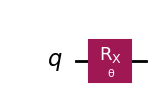

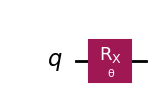

In [22]:
# Parameter have each time a new UUID
theta_1 = Parameter("θ")
qc_1 = QuantumCircuit(1, name="qc")
qc_1.rx(theta_1, 0)

theta_2 = Parameter("θ")
qc_2 = QuantumCircuit(1, name="qc")
qc_2.rx(theta_2, 0)

display(qc_1.draw("mpl"))
display(qc_2.draw("mpl"))

However, their QPY encodings differ.

In [23]:
buffer = io.BytesIO()

qpy.dump(qc_1, file_obj=buffer)
buffer.seek(0)
qpy_1 = buffer.read()

buffer.seek(0)
qpy.dump(qc_2, file_obj=buffer)
buffer.seek(0)
qpy_2 = buffer.read()

# Are QPY encodings of qc_1 and qc_2 identical? No!
print(f"qpy_1 = qpy_2? {qpy_1 == qpy_2}")

qpy_1 = qpy_2? False


In [24]:
tmpdir = tempfile.TemporaryDirectory()

with open(f"{tmpdir.name}/qc_1.qpy", "wb") as file:
    qpy.dump(qc_1, file_obj=file)

with open(f"{tmpdir.name}/qc_2.qpy", "wb") as file:
    qpy.dump(qc_2, file_obj=file)

In [25]:
!diffoscope {tmpdir.name}/*

--- /tmp/tmpelg04uuc/qc_1.qpy
+++ /tmp/tmpelg04uuc/qc_2.qpy
@@ -4,10 +4,10 @@
 00000030: 0200 0000 0100 0000 0000 0000 0100 0000  ................
 00000040: 0071 6300 0000 0000 0000 007b 7d71 0100  .qc........{}q..
 00000050: 0000 0100 0101 7100 0000 0000 0000 0000  ......q.........
 00000060: 0000 0000 0000 0000 0000 0000 0600 0000  ................
 00000070: 0100 0000 0100 0000 0000 0000 0000 0000  ................
 00000080: 0000 0000 0000 0000 0000 0000 5258 4761  ............RXGa
 00000090: 7465 7100 0000 0070 0000 0000 0000 0014  teq....p........
-000000a0: 0002 cbf5 69ba 7a67 4462 8e1e a52e 71a1  ....i.zgDb....q.
-000000b0: 1cf2 ceb8 0000 00ff ffff ffff ffff ffff  ................
+000000a0: 0002 901c c133 4c95 454d b77a 2292 c9ad  .....3L.EM.z"...
+000000b0: 88b1 ceb8 0000 00ff ffff ffff ffff ffff  ................
 000000c0: ffff ff00 0000 0000 0000 00              ...........


In [26]:
tmpdir.cleanup()

In this case, the difference is not as simple to interpret, but it actually corresponds to a 128-bit UUID that changes every time the parameter is instantiated. 

This Python UUID is stored in the QPY encoding.

Avoiding this issue requires manually replacing Qiskit's parameters UUIDs with deterministic ones. The following code demonstrates this workaround.

We create the first circuit exactly the same as above.

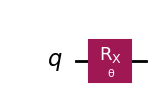

In [27]:
# Parameter have each time a new UUID
theta_1 = Parameter("θ")
qc_1 = QuantumCircuit(1, name="qc")
qc_1.rx(theta_1, 0)
qc_1.draw("mpl")

But now, for the second circuit, we reuse the same UUID from the previous circuit.

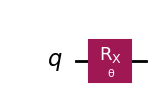

In [28]:
theta_2 = Parameter("θ", uuid=theta_1.uuid)
qc_2 = QuantumCircuit(1, name="qc")
qc_2.rx(theta_2, 0)
qc_2.draw("mpl")

And we can check that the QPY encodings now are the same.

In [29]:
buffer = io.BytesIO()

qpy.dump(qc_1, file_obj=buffer)
buffer.seek(0)
qpy_1 = buffer.read()

buffer.seek(0)
qpy.dump(qc_2, file_obj=buffer)
buffer.seek(0)
qpy_2 = buffer.read()

# Are QPY encodings of qc_1 and qc_2 identical? No!
print(f"qpy_1 = qpy_2? {qpy_1 == qpy_2}")

qpy_1 = qpy_2? True


In practice, instead of a random UUID, Qiskit could use a hash of the parameter's name, so that the QPY encoding is always deterministic. In that case, Qiskit should also enforce that parameters in a circuit have unique names to avoid collisions.

In [30]:
import hashlib
import uuid

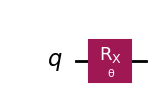

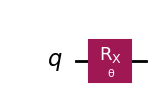

qpy_1 = qpy_2? True


In [31]:
name = "θ"
# As an example, we used the first 16 bytes of the SHA-256 hash of the name
parameter_bytes = hashlib.sha256(name.encode()).digest()[:16]
paramter_uuid = uuid.UUID(bytes=parameter_bytes)

theta_1 = Parameter(name, uuid=paramter_uuid)
qc_1 = QuantumCircuit(1, name="qc")
qc_1.rx(theta_1, 0)

theta_2 = Parameter(name, uuid=paramter_uuid)
qc_2 = QuantumCircuit(1, name="qc")
qc_2.rx(theta_2, 0)

display(qc_1.draw("mpl"))
display(qc_2.draw("mpl"))
print(f"qpy_1 = qpy_2? {qpy_1 == qpy_2}")

<div class="alert alert-block alert-info">

**Solution:** Modify Qiskit to use determinisitc UUIDs for circuit parameters, or use an alternative encoding that does not store random UUIDs since these are not relevant for the quantum computation.
</div>

## Deterministic artifacts with OpenQASM3

All the sources of nondeterminism in the final artifacts shown above caused by QPY (and many others not shown, and future ones with changes in both Qiskit and QPY) can be avoided by constructing the final quantum artifact using OpenQASM3 instead of QPY.

Using the OpenQASM description instead of the QPY encoding makes sense since all the information required to run a quantum circuit in a QPU is already contained there, while all the additional information that can cause nonreproducible circuits (e.g. exact Python objects, UUIDs, etc.) are removed.

In this section we repeat all the experiments from above and show that the new quantum artifacts would be reproducible without any modifications.

### Testing unnamed circuits

In [32]:
from qiskit import qasm3

In [33]:
# Two identical GHZ circuits with identical source code
qc_1 = QuantumCircuit(3)
qc_1.h(0)
qc_1.cx(0, 1)
qc_1.cx(0, 2)

qc_2 = QuantumCircuit(3)
qc_2.h(0)
qc_2.cx(0, 1)
qc_2.cx(0, 2)

buffer = io.BytesIO()

qpy.dump(qc_1, file_obj=buffer)
buffer.seek(0)
qpy_1 = buffer.read()

buffer.seek(0)
qpy.dump(qc_2, file_obj=buffer)
buffer.seek(0)
qpy_2 = buffer.read()

# Are QPY encodings of qc_1 and qc_2 identical? No!
print(f"qpy_1 = qpy_2? {qpy_1 == qpy_2}")

qasm_1 = qasm3.dumps(qc_1)
qasm_2 = qasm3.dumps(qc_2)

# Are OpenQASM3 encodings of qc_1 and qc_2 identical? Yes!
print(f"qasm_1 = qasm_2? {qasm_1 == qasm_2}")

qpy_1 = qpy_2? False
qasm_1 = qasm_2? True


### Testing circuits with parameters

In [34]:
# Parameter have each time a new UUID
theta_1 = Parameter("θ")
qc_1 = QuantumCircuit(1, name="qc")
qc_1.rx(theta_1, 0)

theta_2 = Parameter("θ")
qc_2 = QuantumCircuit(1, name="qc")
qc_2.rx(theta_2, 0)

buffer = io.BytesIO()

qpy.dump(qc_1, file_obj=buffer)
buffer.seek(0)
qpy_1 = buffer.read()

buffer.seek(0)
qpy.dump(qc_2, file_obj=buffer)
buffer.seek(0)
qpy_2 = buffer.read()

# Are QPY encodings of qc_1 and qc_2 identical? No!
print(f"qpy_1 = qpy_2? {qpy_1 == qpy_2}")

qasm_1 = qasm3.dumps(qc_1)
qasm_2 = qasm3.dumps(qc_2)

# Are OpenQASM3 encodings of qc_1 and qc_2 identical? Yes!
print(f"qasm_1 = qasm_2? {qasm_1 == qasm_2}")

qpy_1 = qpy_2? False
qasm_1 = qasm_2? True


### Testing large random transpiled circuits

To ensure that reproducibility is still achieved for larger and more complex quantum circuits, and that no other sources of non-determinism have been overlooked, we repeat the same experiment using a larger circuit as the starting point. In particular, we use 133 qubits, the same number as the largest quantum backend available in IBM's Open Plan.

In [35]:
seed_random_circuit = secrets.randbits(64)
print(f"seed_random_circuit = {seed_random_circuit}")
qc_1 = random_circuit(num_qubits=133, depth=4, measure=True, seed=seed_random_circuit)
qc_2 = random_circuit(num_qubits=133, depth=4, measure=True, seed=seed_random_circuit)

assert qc_1 == qc_2

seed_transpilation = secrets.randbits(64)
print(f"seed_transpilation = {seed_transpilation}")
pm = generate_preset_pass_manager(backend=backend, optimization_level=3, seed_transpiler=seed_transpilation)
isa_qc_1 = pm.run(qc_1)

pm = generate_preset_pass_manager(backend=backend, optimization_level=3, seed_transpiler=seed_transpilation)
isa_qc_2 = pm.run(qc_2)

assert isa_qc_1 == isa_qc_2

buffer = io.BytesIO()

qpy.dump(isa_qc_1, file_obj=buffer)
buffer.seek(0)
qpy_1 = buffer.read()

buffer.seek(0)
qpy.dump(isa_qc_2, file_obj=buffer)
buffer.seek(0)
qpy_2 = buffer.read()

# Are QPY encodings of qc_1 and qc_2 identical? No!
print(f"qpy_1 = qpy_2? {qpy_1 == qpy_2}")

qasm_1 = qasm3.dumps(isa_qc_1)
qasm_2 = qasm3.dumps(isa_qc_2)

# Are OpenQASM3 encodings of qc_1 and qc_2 identical? Yes!
print(f"qasm_1 = qasm_2? {qasm_1 == qasm_2}")

seed_random_circuit = 1005270161485317407
seed_transpilation = 17497683489188034549
qpy_1 = qpy_2? False
qasm_1 = qasm_2? True


<div class="alert alert-block alert-info">

**Solution:** Use OpenQASM 3 instead of QPY as the default encoding format when submitting circuits to the IBM Quantum Platform. This eliminates many sources of non-determinism and already provides a way to achieve reproducible quantum builds.
</div>

## Impact on quantum artifacts size

Lastly, we check the impact of migrating from QPY to OpenQASM3 in terms of payload size. Ideally, the new quantum artifacts should be no larger than the previous ones.

We use a large random circuit as benchmark and we repeat the experiment 100 times to get some statistics.

<div class="alert alert-block alert-warning">

**Note:** The following cell might take a while to run. You can decrease the loop for a quick check.
</div>

In [36]:
qpy_size = []
qasm_size = []

for _ in range(100):
    # Random 133-qubit quantum circuit
    seed_random_circuit = secrets.randbits(64)
    qc = random_circuit(num_qubits=133, depth=4, measure=True, seed=seed_random_circuit)
    seed_transpilation = secrets.randbits(64)
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3, seed_transpiler=seed_transpilation) 
    isa_qc = pm.run(qc)

    # QPY payload
    # The RuntimeEncoder already does the compression and Base64 encoding
    qpy_payload = json.dumps(isa_qc, cls=RuntimeEncoder)
    # We only consider the actual QuantumCircuit encoding, nothing else
    qpy_payload = json.loads(qpy_payload)["__value__"]
    qpy_size.append(len(qpy_payload))

    # QASM3 payload
    qasm_payload = qasm3.dumps(isa_qc)

    qasm_payload = zlib.compress(qasm_payload.encode())
    qasm_payload = base64.standard_b64encode(qasm_payload).decode("utf-8")
    qasm_size.append(len(qasm_payload))

It turns out that using OpenQASM3 instead of QPY not only helps producing reproducible artifacts but also reduces considerably the size of the final payload.

In [37]:
import numpy as np
import matplotlib.pyplot as plt

In [38]:
qasm_size = np.array(qasm_size)
qpy_size = np.array(qpy_size)
comparison = qasm_size / qpy_size
print(f"min reduction in size: {comparison.min():.0%}")
print(f"max reduction in size: {comparison.max():.0%}")
print(f"avg reduction in size: {comparison.mean():.0%}")

min reduction in size: 65%
max reduction in size: 78%
avg reduction in size: 68%


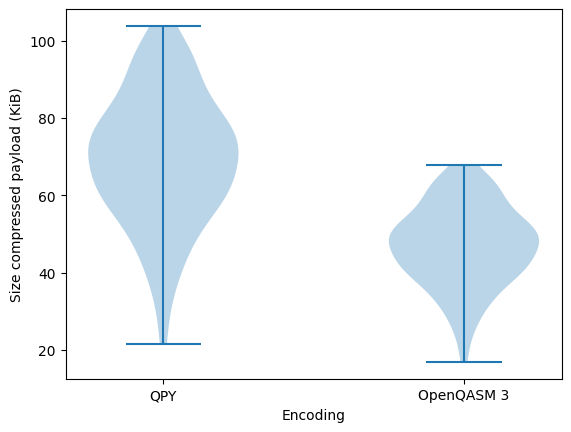

In [39]:
fig, ax = plt.subplots()
ax.violinplot([qpy_size / 1024, qasm_size / 1024])
ax.set_xticks([1, 2])
ax.set_xticklabels(["QPY", "OpenQASM 3"])
ax.set_ylabel("Size compressed payload (KiB)")
ax.set_xlabel("Encoding");